# 1.Import Moduel

In [ ]:
import torch
import torchvision
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import nibabel as nib
import cv2
import torchvision.utils as vutils
from torch.utils.data import Dataset, random_split, DataLoader
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import f1_score # calculate f1-score
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
import re
import pandas as pd
from io import StringIO
from tqdm.notebook import tqdm
%matplotlib inline

## 1.1 Minst 数据集下载

In [ ]:
#The size of train image size
image_size = 64

transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.repeat(3,1,1))# change mnist image from 1 channel to 3,
                               transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
                           ])

In [ ]:
train_data = torchvision.datasets.MNIST(
    root = '/content/',
    train = True, #download train
    transform = transform,
    download = True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [ ]:
test_data = torchvision.datasets.MNIST(
    root = '/content/',
    train = False, #Download test data
    transform = transform,
    download = True
)

In [ ]:
batch_size = 128
dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

## 1.2数据图像查看

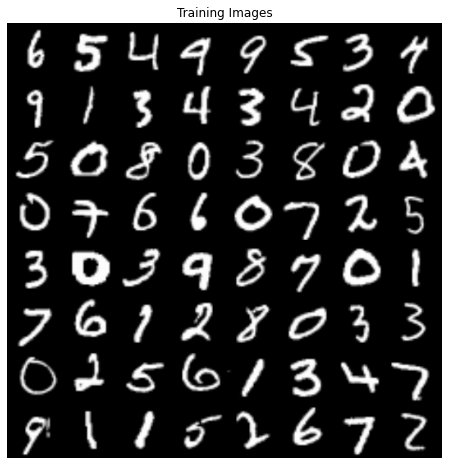

In [ ]:
# choose GPU
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')


# plot part of train dataset
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## 1.3 Weight inital

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## 1.4 basic parameter for model

In [ ]:
#Number of worker threads loading data
workers = 2

#Batch size during training
batch_size = 128


#Train the number of channels in the image. For color images, this is 3
nc = 3

#Size of potential vector Z (e.g., size of generator input)
nz = 100

#The size of the feature graph in the generator
ngf = 64

#The size of the feature map in the discriminator
ndf = 64

#epoch number 
num_epochs = 5

#learning rate
lr = 0.0002

#adam hyperparameter
beta1 = 0.5

#number of GPU, 0 for CPU
ngpu = 1

# 2.Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is Z
            nn.ConvTranspose2d( 100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
 
    def forward(self, x):
      return self.main(x)

In [ ]:
netG = Generator(ngpu).to(device)

In [ ]:
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

#3. Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 64, 1, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(64, 64 * 2, 1, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 1, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 1, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )
 
    def forward(self, x):
      return self.main(x)

In [ ]:
# create Discriminator
netD = Discriminator(ngpu).to(device)
#  apply weights_initFunction randomly initializes ownership weight，mean= 0，stdev = 0.2
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

判别器的训练由两部分组成，第一部分是真的图像判别为真，第二部分是假的图片判别为假，在这两个过程中，生成器的参数不参与更新

# 4.Loss functions and optimizers

In [ ]:
# Initialize the BCELoss function
criterion = nn.BCELoss()

# Create a set of potential vectors that we will use to visualize the generator's progress
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish the practice of true and false labels during training
real_label = 1
fake_label = 0

# Set up Adam optimizer for G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the data loader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        #print(len(data[0]))
        real_cpu = data[0].to(device)
        print(real_cpu.shape)
        b_size = real_cpu.size(0)
        #print(b_size)
        label = torch.full((b_size,), real_label, device=device)
        #print(label.data)
        # Forward pass real batch through D
        output = netD(real_cpu)
        #print(output.data)
        print(output.shape)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label) #!!!!Here is the problem!!!!!!
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
torch.Size([128, 3, 64, 64])
torch.Size([128, 1, 6, 6])


ValueError: ignored

## 2.1生成sample图像

In [ ]:
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable

In [ ]:
for epoch in range(10):
    for i, (img, _) in enumerate(dataloader):
        #print(img)
        num_img = img.size(0)
        #img=img.convert("RGB")
        # =================train discriminator
        real_img = Variable(img).cuda()
        real_label = Variable(torch.ones(num_img)).cuda()
        fake_label = Variable(torch.zeros(num_img)).cuda()
 
        # compute loss of real_img
        real_out = D(real_img)
        #print(real_out)
        #print(real_label)
        d_loss_real = criterion(real_out, real_label)
        real_scores = real_out  # closer to 1 means better
 
        # compute loss of fake_img
        z = Variable(torch.randn(num_img, z_dimension)).cuda()
        #print(z.data)
        fake_img = G(z)
        fake_out = D(fake_img)
        d_loss_fake = criterion(fake_out, fake_label)
        fake_scores = fake_out  # closer to 0 means better
 
        # bp and optimize
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
 
        # ===============train generator
        # compute loss of fake_img
        z = Variable(torch.randn(num_img, z_dimension)).cuda()
        fake_img = G(z)
        output = D(fake_img)
        g_loss = criterion(output, real_label)
 
        # bp and optimize
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
 
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], d_loss: {:.6f}, g_loss: {:.6f} '
                  'D real: {:.6f}, D fake: {:.6f}'
                  .format(epoch, num_epoch, d_loss.data[0], g_loss.data[0],
                          real_scores.data.mean(), fake_scores.data.mean()))
    if epoch == 0:
        real_images = to_img(real_img.cpu().data)
        save_image(real_images, './dc_img/real_images.png')
 
    fake_images = to_img(fake_img.cpu().data)
    save_image(fake_images, './dc_img/fake_images-{}.png'.format(epoch+1))
 
torch.save(G.state_dict(), './generator.pth')
torch.save(D.state_dict(), './discriminator.pth')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored